<img src="Aerolineas Europa 2025.jpg" width="50%" alt="Portada">

#### Importaciones

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import pickle
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, confusion_matrix
import joblib
import os

# Importar modelos
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.cluster import KMeans

#### Carga de datos 

In [40]:
df = pd.read_csv('../data/train/train_limpio.csv')

In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103594 entries, 0 to 103593
Data columns (total 20 columns):
 #   Column                                 Non-Null Count   Dtype  
---  ------                                 --------------   -----  
 0   Genero                                 103594 non-null  int64  
 1   Edad                                   103594 non-null  int64  
 2   Tipo de viaje                          103594 non-null  int64  
 3   Clase                                  103594 non-null  int64  
 4   Distancia del vuelo                    103594 non-null  int64  
 5   Servicio wifi a bordo                  103594 non-null  int64  
 6   Horario de salida/llegada conveniente  103594 non-null  int64  
 7   Facilidad para reservar online         103594 non-null  int64  
 8   Comida y bebida                        103594 non-null  int64  
 9   Embarque online                        103594 non-null  int64  
 10  Comodidad del asiento                  103594 non-null  

Columna = "Retraso en la llegada en minutos":        310 nulos - "0.3%"

### Cantidad de pasajeros satisfechos & insatisfechos

In [42]:
df['Satisfacción'].value_counts()

Satisfacción
0    58697
1    44897
Name: count, dtype: int64

#### Eliminar los nulos de la columna "Retraso en la llegada en minutos"

In [43]:
print("Tamaño antes de eliminar nulos:", df.shape)

df = df.dropna(subset=['Retraso en la llegada en minutos'])

print("Tamaño después de eliminar nulos:", df.shape)

Tamaño antes de eliminar nulos: (103594, 20)
Tamaño después de eliminar nulos: (103594, 20)


In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103594 entries, 0 to 103593
Data columns (total 20 columns):
 #   Column                                 Non-Null Count   Dtype  
---  ------                                 --------------   -----  
 0   Genero                                 103594 non-null  int64  
 1   Edad                                   103594 non-null  int64  
 2   Tipo de viaje                          103594 non-null  int64  
 3   Clase                                  103594 non-null  int64  
 4   Distancia del vuelo                    103594 non-null  int64  
 5   Servicio wifi a bordo                  103594 non-null  int64  
 6   Horario de salida/llegada conveniente  103594 non-null  int64  
 7   Facilidad para reservar online         103594 non-null  int64  
 8   Comida y bebida                        103594 non-null  int64  
 9   Embarque online                        103594 non-null  int64  
 10  Comodidad del asiento                  103594 non-null  

#### Establecer la y= target 

In [45]:
X = df.drop(columns= ['Satisfacción'])
y = df['Satisfacción']

#### Dividir en Train y Test 

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### Escalar los datos

In [47]:
# Escalar los datos (StandardScaler)

scaler = StandardScaler()

scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Train shape", X_train_scaled.shape)
print("Test shape", X_test_scaled.shape)

Train shape (82875, 19)
Test shape (20719, 19)


In [48]:
models = '../models'

# Asegurarnos de que el directorio exista (por seguridad)
if not os.path.exists(models):
    os.makedirs(models)
# Ruta completa del archivo
scaler_filename = os.path.join(models, 'scaler.pkl')
joblib.dump(scaler, scaler_filename)
print(f"Scaler guardado exitosamente en: {scaler_filename}")

Scaler guardado exitosamente en: ../models\scaler.pkl


## Modelos

### Logistic Regresion / Regresión Logística


📊 RESULTADOS: REGRESIÓN LOGÍSTICA
⚙️ Mejores Parámetros: {'C': 0.1, 'solver': 'liblinear'}
------------------------------
✅ Accuracy:  85.81%
🎯 Precision: 85.79%
🔍 Recall:    85.81%
⚖️ F1-Score:  85.78%


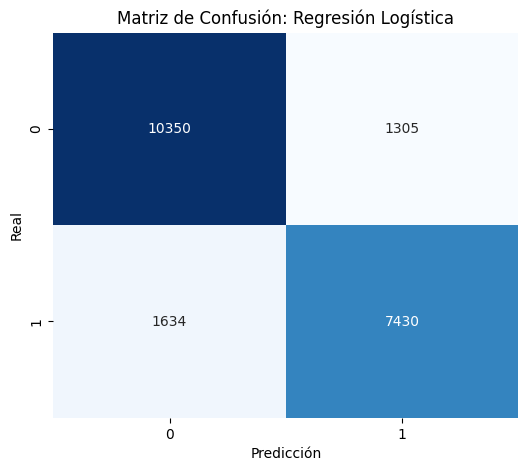

In [49]:
# Definir parámetros
param_grid_lr = {
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['lbfgs', 'liblinear']}

# Configurar GridSearch
grid_lr = GridSearchCV(
    LogisticRegression(max_iter=1000, random_state=42),
    param_grid_lr,
    cv=5,
    scoring='f1_weighted',
    n_jobs=-1)

# Entrenamiento
grid_lr.fit(X_train_scaled, y_train)
best_lr = grid_lr.best_estimator_

# Predicción
y_pred_lr = best_lr.predict(X_test_scaled)

# Métricas
acc_lr = accuracy_score(y_test, y_pred_lr)
prec_lr = precision_score(y_test, y_pred_lr, average='weighted')
rec_lr = recall_score(y_test, y_pred_lr, average='weighted')
f1_lr = f1_score(y_test, y_pred_lr, average='weighted')

print(f"\n📊 RESULTADOS: REGRESIÓN LOGÍSTICA")
print(f"⚙️ Mejores Parámetros: {grid_lr.best_params_}")
print("-" * 30)
print(f"✅ Accuracy:  {acc_lr:.2%}")
print(f"🎯 Precision: {prec_lr:.2%}")
print(f"🔍 Recall:    {rec_lr:.2%}")
print(f"⚖️ F1-Score:  {f1_lr:.2%}")

# Gráfico de confusión
# Crear matriz de confusión
cm = confusion_matrix(y_test, y_pred_lr)

# Visualización gráfica
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Matriz de Confusión: Regresión Logística')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.show()

In [50]:
lr_filename = os.path.join(models, 'regresion_logistica.pkl')
joblib.dump(best_lr, lr_filename)
print(f"Modelo Regresión Logística guardado exitosamente en: {lr_filename}")

Modelo Regresión Logística guardado exitosamente en: ../models\regresion_logistica.pkl


#### Decision Tree (Árbol de Decisión)

In [51]:
# Definir parámetros
param_grid_dt = {
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 10, 20],
    'min_samples_leaf': [1, 5, 10],
    'criterion': ['gini', 'entropy']}

# Configurar GridSearch
grid_dt = GridSearchCV(
    DecisionTreeClassifier(random_state=42),
    param_grid_dt,
    cv=5,
    scoring='f1_weighted',
    n_jobs=-1)

# Entrenar
grid_dt.fit(X_train_scaled, y_train) 
best_dt = grid_dt.best_estimator_

# Predicción
y_pred_dt = best_dt.predict(X_test_scaled)

# Métricas
acc_dt = accuracy_score(y_test, y_pred_dt)
prec_dt = precision_score(y_test, y_pred_dt, average='weighted')
rec_dt = recall_score(y_test, y_pred_dt, average='weighted')
f1_dt = f1_score(y_test, y_pred_dt, average='weighted')

print(f"\n📊 RESULTADOS: ÁRBOL DE DECISIÓN")
print(f"⚙️ Mejores Parámetros: {grid_dt.best_params_}")
print("-" * 30)
print(f"✅ Accuracy:  {acc_dt:.2%}")
print(f"🎯 Precision: {prec_dt:.2%}")
print(f"🔍 Recall:    {rec_dt:.2%}")
print(f"⚖️ F1-Score:  {f1_dt:.2%}")


📊 RESULTADOS: ÁRBOL DE DECISIÓN
⚙️ Mejores Parámetros: {'criterion': 'gini', 'max_depth': 20, 'min_samples_leaf': 5, 'min_samples_split': 20}
------------------------------
✅ Accuracy:  94.16%
🎯 Precision: 94.16%
🔍 Recall:    94.16%
⚖️ F1-Score:  94.16%


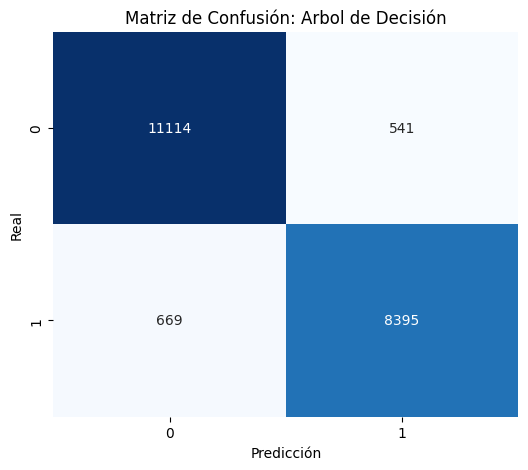

In [52]:
# Crear matriz de confusión
cm = confusion_matrix(y_test, y_pred_dt)

# Visualización gráfica
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Matriz de Confusión: Arbol de Decisión')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.show()

In [53]:
dt_filename = os.path.join(models, 'arbol_decision.pkl')
joblib.dump(best_dt, dt_filename)
print(f"Modelo Árbol de Decisión guardado exitosamente en: {dt_filename}")

Modelo Árbol de Decisión guardado exitosamente en: ../models\arbol_decision.pkl


#### Random Forest

In [54]:
# Definir parámetros
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, None],
    'min_samples_leaf': [1, 4]}

# Configurar GridSearch
grid_rf = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid_rf,
    cv=3, 
    scoring='f1_weighted',
    n_jobs=-1)

# Entrenar
grid_rf.fit(X_train_scaled, y_train)
best_rf = grid_rf.best_estimator_

# Predicción
y_pred_rf = best_rf.predict(X_test_scaled)

# Métricas
acc_rf = accuracy_score(y_test, y_pred_rf)
prec_rf = precision_score(y_test, y_pred_rf, average='weighted')
rec_rf = recall_score(y_test, y_pred_rf, average='weighted')
f1_rf = f1_score(y_test, y_pred_rf, average='weighted')

print(f"\n📊 RESULTADOS: RANDOM FOREST")
print(f"⚙️ Mejores Parámetros: {grid_rf.best_params_}")
print("-" * 30)
print(f"✅ Accuracy:  {acc_rf:.2%}")
print(f"🎯 Precision: {prec_rf:.2%}")
print(f"🔍 Recall:    {rec_rf:.2%}")
print(f"⚖️ F1-Score:  {f1_rf:.2%}")


📊 RESULTADOS: RANDOM FOREST
⚙️ Mejores Parámetros: {'max_depth': 20, 'min_samples_leaf': 1, 'n_estimators': 200}
------------------------------
✅ Accuracy:  95.67%
🎯 Precision: 95.70%
🔍 Recall:    95.67%
⚖️ F1-Score:  95.66%


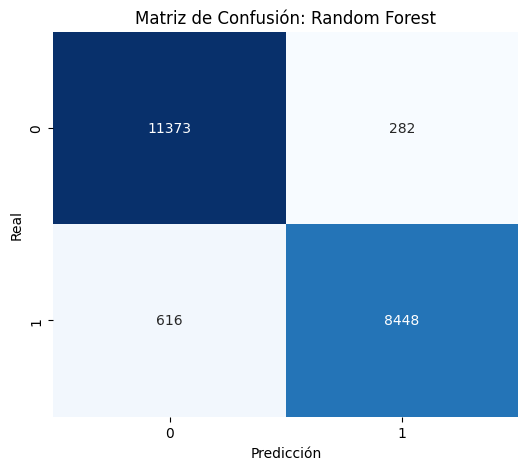

In [55]:
# Crear matriz de confusión
cm = confusion_matrix(y_test, y_pred_rf)

# Visualización gráfica
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Matriz de Confusión: Random Forest')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.show()

In [56]:
import os
import joblib
from sklearn.ensemble import RandomForestClassifier

# Definir la ruta
models = '../models'
if not os.path.exists(models):
    os.makedirs(models)

# --- CONFIGURACIÓN PARA REDUCIR TAMAÑO ---

rf_light = RandomForestClassifier(
    n_estimators=100,      
    max_depth=15,          
    min_samples_leaf=5,    
    random_state=42,
    n_jobs=-1)

# Entrenar (asumiendo que X_train_scaled y y_train existen)
if 'X_train_scaled' in globals():
    rf_light.fit(X_train_scaled, y_train)
    
    # --- GUARDADO CON COMPRESIÓN ---
    rf_filename = os.path.join(models, 'random_forest.pkl')
    
   
    joblib.dump(rf_light, rf_filename, compress=3)
    
    # --- VERIFICACIÓN DE TAMAÑO ---
    file_size_bytes = os.path.getsize(rf_filename)
    file_size_mb = file_size_bytes / (1024 * 1024)
    
    print(f"Modelo guardado en: {rf_filename}")
    print(f"Tamaño del archivo: {file_size_mb:.2f} MB")
    
    if file_size_mb < 100:
        print("🎉 ¡OBJETIVO CUMPLIDO! El archivo pesa menos de 100 MB.")
    else:
        print("⚠️ AVISO: Aún es muy grande. Prueba reducir 'max_depth' a 10.")

else:
    print("❌ Error: No se encontraron los datos de entrenamiento (X_train_scaled).")

Modelo guardado en: ../models\random_forest.pkl
Tamaño del archivo: 5.81 MB
🎉 ¡OBJETIVO CUMPLIDO! El archivo pesa menos de 100 MB.


#### Gradient Boosting

In [57]:
# Definir parámetros
gb = GradientBoostingClassifier(random_state=42)

param_grid = {'n_estimators': [100, 200],      
              'learning_rate': [0.05, 0.1, 0.2], 
              'max_depth': [3, 5]}

# Configurar GridSearch 
grid_gb = GridSearchCV(estimator=gb,  param_grid=param_grid, cv=3, n_jobs=-1)

# Entrenar
grid_gb.fit(X_train_scaled, y_train)
best_gb = grid_gb.best_estimator_

# Predicción
y_pred_gb = best_gb.predict(X_test_scaled)

# Métricas
acc_gb = accuracy_score(y_test, y_pred_gb)
prec_gb = precision_score(y_test, y_pred_gb, average='weighted')
rec_gb = recall_score(y_test, y_pred_gb, average='weighted')
f1_gb = f1_score(y_test, y_pred_gb, average='weighted')

print(f"\n📊 RESULTADOS: GRADIENT BOOSTING")
print(f"⚙️ Mejores Parámetros: {grid_gb.best_params_}")
print("-" * 30)
print(f"✅ Accuracy:  {acc_gb:.2%}")
print(f"🎯 Precision: {prec_gb:.2%}")
print(f"🔍 Recall:    {rec_gb:.2%}")
print(f"⚖️ F1-Score:  {f1_gb:.2%}")


📊 RESULTADOS: GRADIENT BOOSTING
⚙️ Mejores Parámetros: {'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 200}
------------------------------
✅ Accuracy:  95.54%
🎯 Precision: 95.56%
🔍 Recall:    95.54%
⚖️ F1-Score:  95.53%


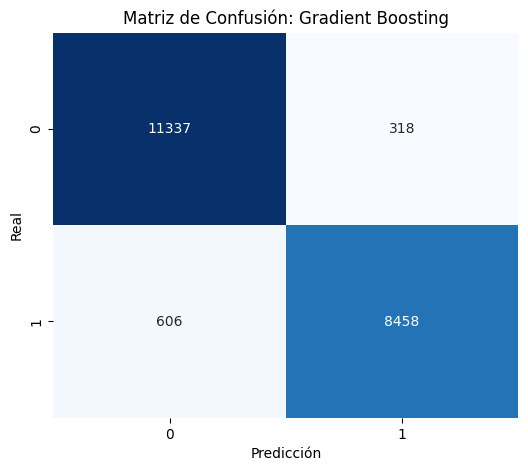

In [58]:
# Matriz de confusión
cm = confusion_matrix(y_test, y_pred_gb)

# Visualización gráfica
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Matriz de Confusión: Gradient Boosting')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.show()


In [59]:
gb_filename = os.path.join(models, 'gradient_boosting.pkl')
joblib.dump(best_gb, gb_filename)
print(f"Modelo Gradient Boosting guardado exitosamente en: {gb_filename}")

Modelo Gradient Boosting guardado exitosamente en: ../models\gradient_boosting.pkl


## XGBoost

In [60]:
# Definir parámetros para GridSearch
param_grid_xgb = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 6]}

# Configurar GridSearch
grid_xgb = GridSearchCV(
    XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    param_grid_xgb,
    cv=3,                
    scoring='accuracy', 
    n_jobs=-1)

# Entrenar
grid_xgb.fit(X_train_scaled, y_train)
best_xgb = grid_xgb.best_estimator_

# Predicción
y_pred_xgb = best_xgb.predict(X_test_scaled)

# Métricas
acc_xgb = accuracy_score(y_test, y_pred_xgb)
prec_xgb = precision_score(y_test, y_pred_xgb, average='weighted')
rec_xgb = recall_score(y_test, y_pred_xgb, average='weighted')
f1_xgb = f1_score(y_test, y_pred_xgb, average='weighted')

print(f"\n📊 RESULTADOS: XGBOOST")
print(f"⚙️ Mejores Parámetros: {grid_xgb.best_params_}")
print("-" * 30)
print(f"✅ Accuracy:  {acc_xgb:.2%}")
print(f"🎯 Precision: {prec_xgb:.2%}")
print(f"🔍 Recall:    {rec_xgb:.2%}")
print(f"⚖️ F1-Score:  {f1_xgb:.2%}")

c:\Users\mikel\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:199: UserWarning: [21:33:24] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



📊 RESULTADOS: XGBOOST
⚙️ Mejores Parámetros: {'learning_rate': 0.2, 'max_depth': 6, 'n_estimators': 200}
------------------------------
✅ Accuracy:  95.88%
🎯 Precision: 95.90%
🔍 Recall:    95.88%
⚖️ F1-Score:  95.87%


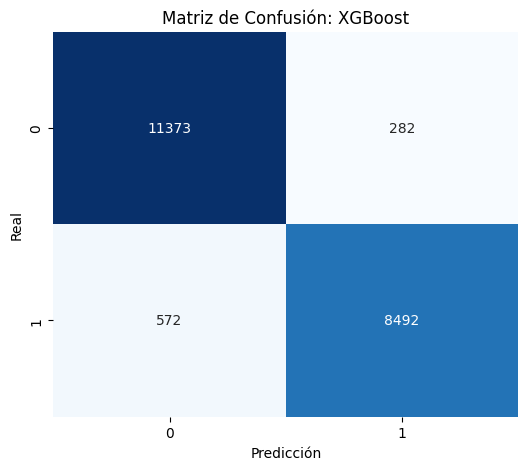

In [61]:
# Crear matriz de confusión
cm_xgb = confusion_matrix(y_test, y_pred_xgb)

# Visualización gráfica
plt.figure(figsize=(6, 5))
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Matriz de Confusión: XGBoost')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.show()

#### KNN (K-Nearest Neighbors)

In [62]:
# Definir parámetros
param_grid_knn = {
    'n_neighbors': [3, 5, 7, 11],
    'weights': ['uniform', 'distance'],
    'p': [1, 2]} # 1=Manhattan, 2=Euclidean

# Configurar GridSearch
grid_knn = GridSearchCV(
    KNeighborsClassifier(),
    param_grid_knn,
    cv=3,
    scoring='f1_weighted',
    n_jobs=-1)

# Entrenar
grid_knn.fit(X_train_scaled, y_train)
best_knn = grid_knn.best_estimator_

# Predicción
y_pred_knn = best_knn.predict(X_test_scaled)

# Métricas
acc_knn = accuracy_score(y_test, y_pred_knn)
prec_knn = precision_score(y_test, y_pred_knn, average='weighted')
rec_knn = recall_score(y_test, y_pred_knn, average='weighted')
f1_knn = f1_score(y_test, y_pred_knn, average='weighted')

print(f"\n📊 RESULTADOS: KNN")
print(f"⚙️ Mejores Parámetros: {grid_knn.best_params_}")
print("-" * 30)
print(f"✅ Accuracy:  {acc_knn:.2%}")
print(f"🎯 Precision: {prec_knn:.2%}")
print(f"🔍 Recall:    {rec_knn:.2%}")
print(f"⚖️ F1-Score:  {f1_knn:.2%}")


📊 RESULTADOS: KNN
⚙️ Mejores Parámetros: {'n_neighbors': 11, 'p': 1, 'weights': 'distance'}
------------------------------
✅ Accuracy:  93.58%
🎯 Precision: 93.64%
🔍 Recall:    93.58%
⚖️ F1-Score:  93.55%


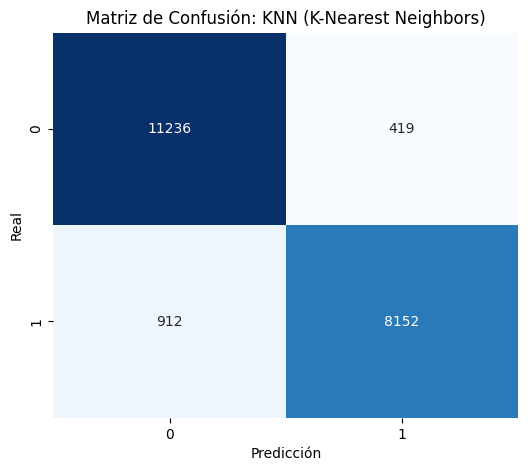

In [63]:
# Crear matriz de confusión
cm = confusion_matrix(y_test, y_pred_knn)

# Visualización gráfica
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Matriz de Confusión: KNN (K-Nearest Neighbors)')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.show()

In [64]:
knn_path = os.path.join(models, 'knn.pkl')
joblib.dump(best_knn, knn_path)
print(f"Modelo KNN guardado exitosamente en: {knn_path}\n")

Modelo KNN guardado exitosamente en: ../models\knn.pkl



#### SVC (Support Vector Classifier)

In [65]:
# Definir parámetros
param_grid_svc = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']}

# Configurar GridSearch
grid_svc = GridSearchCV(
    SVC(random_state=42),
    param_grid_svc,
    cv=3,
    scoring='f1_weighted',
    n_jobs=-1)

# Entrenamiento
grid_svc.fit(X_train_scaled[:10000], y_train[:10000]) 
best_svc = grid_svc.best_estimator_

# Predicción 
y_pred_svc = best_svc.predict(X_test_scaled)

# D. Métricas
acc_svc = accuracy_score(y_test, y_pred_svc)
prec_svc = precision_score(y_test, y_pred_svc, average='weighted')
rec_svc = recall_score(y_test, y_pred_svc, average='weighted')
f1_svc = f1_score(y_test, y_pred_svc, average='weighted')

print(f"\n📊 RESULTADOS: SVC (Entrenado con muestra reducida)")
print(f"⚙️ Mejores Parámetros: {grid_svc.best_params_}")
print("-" * 30)
print(f"✅ Accuracy:  {acc_svc:.2%}")
print(f"🎯 Precision: {prec_svc:.2%}")
print(f"🔍 Recall:    {rec_svc:.2%}")
print(f"⚖️ F1-Score:  {f1_svc:.2%}")


📊 RESULTADOS: SVC (Entrenado con muestra reducida)
⚙️ Mejores Parámetros: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
------------------------------
✅ Accuracy:  93.61%
🎯 Precision: 93.64%
🔍 Recall:    93.61%
⚖️ F1-Score:  93.60%


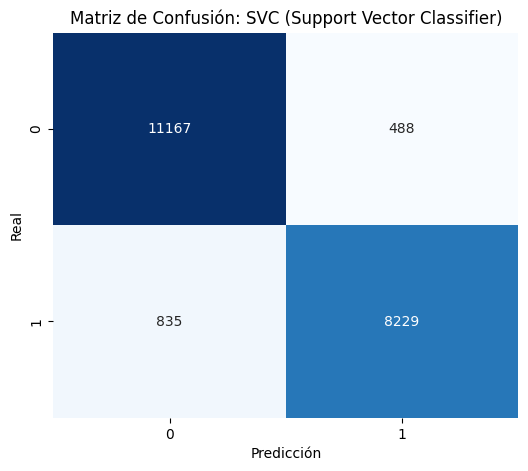

In [66]:
# Crear matriz de confusión
cm = confusion_matrix(y_test, y_pred_svc)

# Visualización gráfica
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Matriz de Confusión: SVC (Support Vector Classifier)')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.show()

In [67]:
svc_path = os.path.join(models, 'svc.pkl')
joblib.dump(best_svc, svc_path)
print(f"Modelo SVC guardado exitosamente en: {svc_path}\n")

Modelo SVC guardado exitosamente en: ../models\svc.pkl



#### KMeans (Clustering - No Supervisado)

In [68]:

kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
# Definir parámetros
# Fijamos n_clusters=2 porque sabemos que la salida es binaria (Satisfacción 0 o 1)
param_grid_km = {
    'init': ['k-means++', 'random'],
    'n_init': [10, 20],
    'max_iter': [300, 500]}

# Configurar GridSearch
# Nota: KMeans no usa 'accuracy' en scoring por defecto, usa inercia negativa.
grid_km = GridSearchCV(
    KMeans(n_clusters=2, random_state=42),
    param_grid_km,
    cv=3,
    n_jobs=-1)
param_grid_km = {
    'init': ['k-means++', 'random'],
    'n_init': [10, 20],
    'max_iter': [300, 500]}

# Entrenar
grid_km.fit(X_train_scaled) 

# Obtener el mejor modelo
best_km = grid_km.best_estimator_
y_pred_km = best_km.predict(X_test_scaled)


# Calcular accuracy temporal
acc_temp = accuracy_score(y_test, y_pred_km)


if acc_temp < 0.5:
    print(f"🔄 Accuracy inicial ({acc_temp:.2%}) bajo. Invirtiendo etiquetas (0 <-> 1)...")
    y_pred_km = 1 - y_pred_km # Invertimos ceros y unos matemáticamente

# Métricas
acc_km = accuracy_score(y_test, y_pred_km)
prec_km = precision_score(y_test, y_pred_km, average='weighted')
rec_km = recall_score(y_test, y_pred_km, average='weighted')
f1_km = f1_score(y_test, y_pred_km, average='weighted')

print(f"\n📊 RESULTADOS: KMEANS (Optimizado)")
print(f"⚙️ Mejores Parámetros: {grid_km.best_params_}")
print("-" * 30)
print(f"✅ Accuracy:  {acc_km:.2%}")
print(f"🎯 Precision: {prec_km:.2%}")
print(f"🔍 Recall:    {rec_km:.2%}")
print(f"⚖️ F1-Score:  {f1_km:.2%}")

🔄 Accuracy inicial (23.94%) bajo. Invirtiendo etiquetas (0 <-> 1)...

📊 RESULTADOS: KMEANS (Optimizado)
⚙️ Mejores Parámetros: {'init': 'k-means++', 'max_iter': 300, 'n_init': 20}
------------------------------
✅ Accuracy:  76.06%
🎯 Precision: 77.33%
🔍 Recall:    76.06%
⚖️ F1-Score:  76.14%


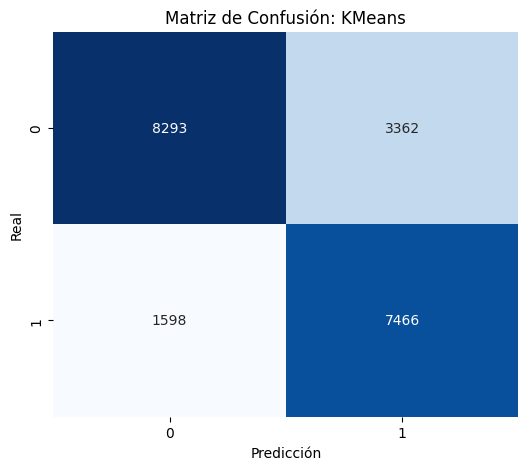

In [69]:
# Crear matriz de confusión (usando 'y_pred_km')
cm = confusion_matrix(y_test, y_pred_km)

# Visualización gráfica
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Matriz de Confusión: KMeans')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.show()

In [70]:
kmeans_path = os.path.join(models, 'kmeans.pkl')
joblib.dump(kmeans, kmeans_path)
print(f"Modelo KMeans guardado exitosamente en: {kmeans_path}")

Modelo KMeans guardado exitosamente en: ../models\kmeans.pkl


C:\Users\mikel\AppData\Local\Temp\ipykernel_3008\1865925713.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Accuracy', y='Modelo', data=df, palette='viridis')


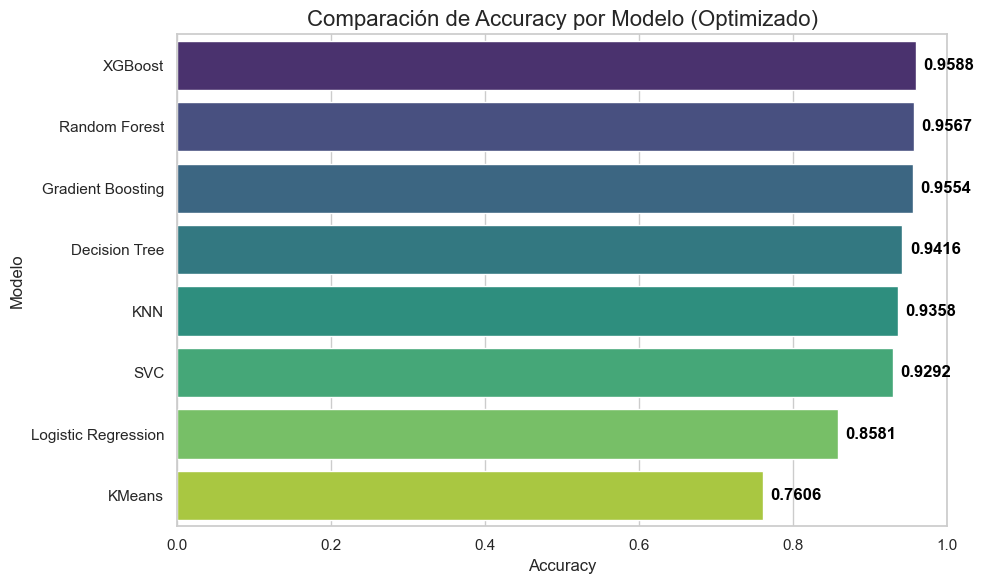

In [71]:
# Datos de accuracy (usando los optimizados como referencia)
data = {
    'Modelo': ['Logistic Regression', 'Decision Tree', 'Random Forest', 'Gradient Boosting', 'XGBoost', 'KNN', 'SVC', 'KMeans'],
    'Accuracy': [0.8581, 0.9416, 0.9567, 0.9554, 0.9588, 0.9358, 0.9292, 0.7606]}

df = pd.DataFrame(data)
# Ordenar de mayor a menor
df = df.sort_values(by='Accuracy', ascending=False)

# Configuración de estilo
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 6))

# Gráfico de barras
sns.barplot(x='Accuracy', y='Modelo', data=df, palette='viridis')

plt.title('Comparación de Accuracy por Modelo (Optimizado)', fontsize=16)
plt.xlabel('Accuracy', fontsize=12)
plt.ylabel('Modelo', fontsize=12)
plt.xlim(0, 1.0)

# Añadir etiquetas de valor
for i, v in enumerate(df['Accuracy']):
    plt.text(v + 0.01, i, f"{v:.4f}", color='black', va='center', fontweight='bold')

plt.tight_layout()
plt.savefig('comparacion_unica_accuracy_final.png')
plt.show()

C:\Users\mikel\AppData\Local\Temp\ipykernel_3008\3302158236.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='F1-Score', y='Modelo', data=df, palette='magma')


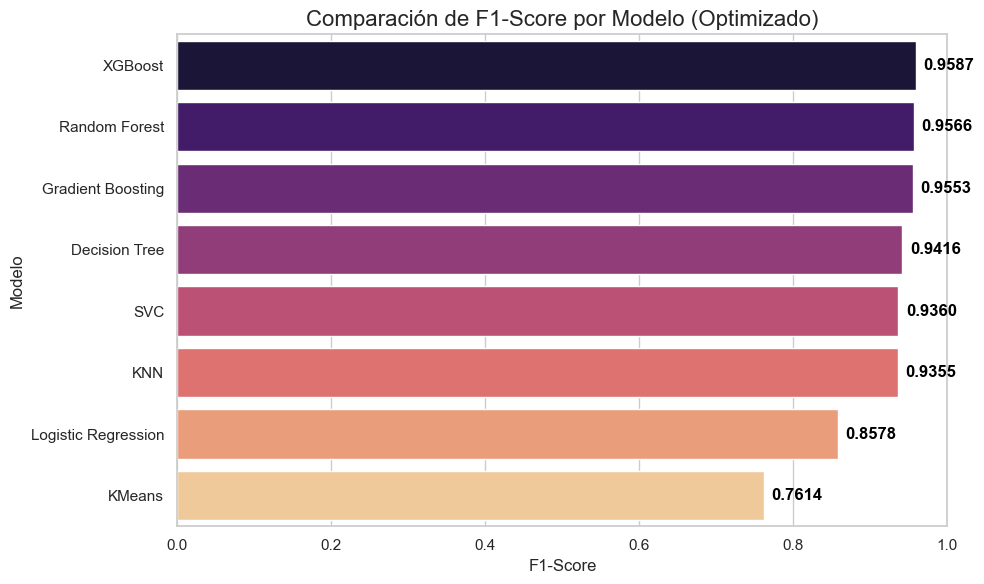

In [73]:
# Datos de F1-score extraídos de los resultados de tus modelos optimizados
data_f1 = {'Modelo': ['Logistic Regression', 'Decision Tree', 'Random Forest', 
                      'Gradient Boosting', 'XGBoost', 'KNN', 'SVC', 'KMeans'],
                      'F1-Score': [0.8578, 0.9416, 0.9566, 0.9553, 0.9587, 0.9355, 0.9360, 0.7614]}

df = pd.DataFrame(data_f1)

# Ordenar de mayor a menor para facilitar la lectura
df = df.sort_values(by='F1-Score', ascending=False)

# Configuración de estilo
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 6))

# Gráfico de barras (usando una paleta distinta para diferenciarla de la de Accuracy)
sns.barplot(x='F1-Score', y='Modelo', data=df, palette='magma')

plt.title('Comparación de F1-Score por Modelo (Optimizado)', fontsize=16)
plt.xlabel('F1-Score', fontsize=12)
plt.ylabel('Modelo', fontsize=12)
plt.xlim(0, 1.0)

# Añadir etiquetas de valor a la derecha de cada barra
for i, v in enumerate(df['F1-Score']):
    plt.text(v + 0.01, i, f"{v:.4f}", color='black', va='center', fontweight='bold')

plt.tight_layout()
plt.savefig('comparacion_f1_score_final.png')
plt.show()

In [72]:
models = '../models'
best_model = grid_xgb.best_estimator_
final_model_path = os.path.join(models, 'mejor_modelo_xgb.pkl')
joblib.dump(best_model, final_model_path)
print(f"Modelo final guardado en: {final_model_path}")

Modelo final guardado en: ../models\mejor_modelo_xgb.pkl
